In [1]:
from six.moves import cPickle as pickle

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

import os as os
import fnmatch
import argparse
import pathlib
import time
import itertools

import numpy as np
if "DISPLAY" not in os.environ:
    mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.io as sio
import glob 

from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold  # k-fold cross validation StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler  # data normalization
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier  # random forest model
from sklearn.pipeline import Pipeline # model pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import make_scorer


%reload_ext autoreload

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')

plt.rcParams.update({'font.size': 22})
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2



In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
knownNames = glob.glob("../dataset/Dados_SONAR/[DEFH]*.mat")

unknownNames = glob.glob("../dataset/Dados_SONAR/[ABCG]*.mat")

X = [sio.loadmat(x)['ent_norm'] for x in knownNames]

X_unknown = [sio.loadmat(x)['ent_norm'] for x in unknownNames]



Y = [(x.split('/')[-1][0]) for x in knownNames]
Y = ['A' if y=='E' else y for y in Y]
Y = ['B' if y!='A' else y for y in Y]

print(Y)

le = LabelEncoder()
target = le.fit_transform(Y)

print(target)


['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [4]:
def increase_samples(data, wLength, ovSamples, label=None):
    
    y = []
    newLabel = []
    for counter, x in enumerate(data):
        size = np.shape(x)[0]
        beginWindowIndex = 0
        endWindowIndex = wLength
        if label is None:
            label2 = []
        else:    
            label2 = label[counter]
        
        while True:
            vector = np.reshape(x[beginWindowIndex:endWindowIndex,:], -1)
            y.append(vector)
            beginWindowIndex = beginWindowIndex + ovSamples
            endWindowIndex = endWindowIndex + ovSamples
            newLabel.append(label2)
            if endWindowIndex > size:
                break
            
    y = np.stack(y)
    return y, newLabel 

In [5]:
windowLength = 1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)


In [7]:
xMatrixTrainExtended,y_trainExtended = increase_samples(X_train, windowLength, 1, y_train)
# print(xMatrixTrainExtended.shape)
# print(xMatrix.shape)
# print(len(y_trainExtended))

In [8]:
model = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])
# model = Pipeline([('reduce_dim', PCA()), ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])


In [9]:
xMatrixTest = np.stack([x[:windowLength,:].reshape(-1) for x in X_test])


In [10]:
fold = StratifiedKFold(10)


In [11]:
# parameters = {'pca__n_components': [252], 'rf__n_estimators': [82], 'rf__n_jobs': [-1],
#               'rf__min_samples_leaf': [35], 'rf__criterion': ['gini']}
metric = metrics.make_scorer(metrics.accuracy_score)
# metric = metrics.make_scorer(metrics.precision_score, average='weighted')



parameters = {'pca__n_components': sp_randint(10, 500), 'rf__n_estimators': sp_randint(10, 100), 'rf__n_jobs': [-1],
              'rf__min_samples_leaf': sp_randint(1, 100), 'rf__criterion': ['gini']}


# parameters = {'pca__n_components': sp_randint(10, 200)}

gridsearchcv = RandomizedSearchCV(model, parameters, scoring=metric, cv=fold, n_iter=10)

print(xMatrixTrainExtended.shape)

# gridsearchcv = GridSearchCV(model, parameters, n_jobs=3, cv=fold, scoring=metric)
gridsearchcv.fit(xMatrixTrainExtended, y_trainExtended)

(11251, 557)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_node...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe81f370710>, 'rf__criterion': ['gini'], 'rf__n_jobs': [-1], 'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe81f370210>, 'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe81f370150>},
          pr

In [12]:
gridsearchcv.cv_results_

/home/felipe/miniconda2/envs/siemens2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/felipe/miniconda2/envs/siemens2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/felipe/miniconda2/envs/siemens2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

{'mean_fit_time': array([ 3.58657069,  2.80271661,  1.56071692,  4.05908103,  2.53735693,
         1.16298685,  3.37169902,  2.15643101,  2.42724469,  2.61929784]),
 'mean_score_time': array([ 0.14759839,  0.14476552,  0.13907077,  0.15555046,  0.14660027,
         0.14531043,  0.15283375,  0.14148216,  0.14863439,  0.15243351]),
 'mean_test_score': array([ 0.92516221,  0.9224069 ,  0.93582793,  0.91289663,  0.9176962 ,
         0.93396143,  0.92009599,  0.92640654,  0.91654075,  0.93849436]),
 'mean_train_score': array([ 0.97726619,  0.98741839,  0.99686942,  0.97109389,  0.98487049,
         0.98965033,  0.97074823,  0.98201647,  0.97049154,  0.99894331]),
 'param_pca__n_components': masked_array(data = [307 391 169 431 282 59 435 283 287 124],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_rf__criterion': masked_array(data = ['gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini'],
              mas

{'pca__n_components': 124, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 87, 'rf__min_samples_leaf': 4}
(array([ 0.92516221,  0.9224069 ,  0.93582793,  0.91289663,  0.9176962 ,
        0.93396143,  0.92009599,  0.92640654,  0.91654075,  0.93849436]), array([ 0.05190293,  0.05853011,  0.07040324,  0.05630528,  0.06956469,
        0.07955189,  0.05826435,  0.05873206,  0.05321143,  0.06866708]))
Normalized confusion matrix
[[ 0.93446852  0.06553148]
 [ 0.01431181  0.98568819]]


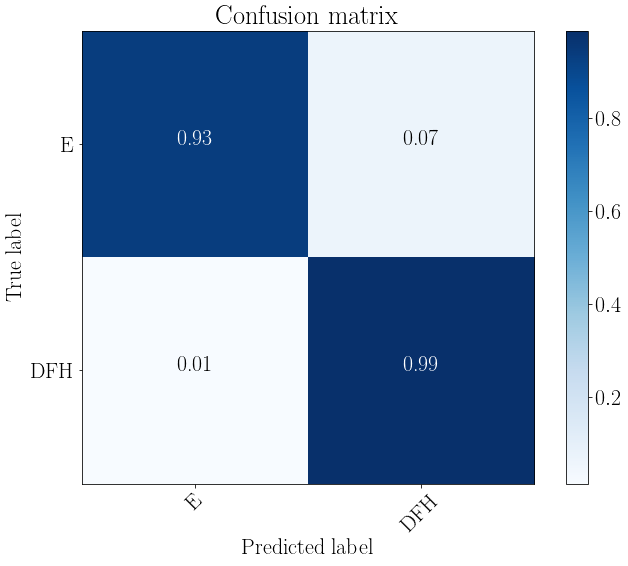

In [16]:
best_n_components = gridsearchcv.best_params_['pca__n_components']

xMatrixTestExtended,y_testExtended = increase_samples(X_test, windowLength, 1, y_test)
xMatrixUnknownExtended,_ = increase_samples(X_unknown, windowLength, 1)

print(gridsearchcv.best_params_)
means = gridsearchcv.cv_results_['mean_test_score']
stds = gridsearchcv.cv_results_['std_test_score']

print(means,stds)
# print(zip(gridsearchcv.best_estimator_.predict_proba(xMatrixTestExtended), np.array(y_testExtended)))
acc = metrics.accuracy_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended))
F1 = metrics.f1_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended), average='weighted')
prec = metrics.precision_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended), average='weighted')

confusionMatrix = metrics.confusion_matrix(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended))

plt.figure()
plot_confusion_matrix(confusionMatrix,normalize=True, classes=['E', 'DFH'])
# print(np.max(resultsTest,axis=1))


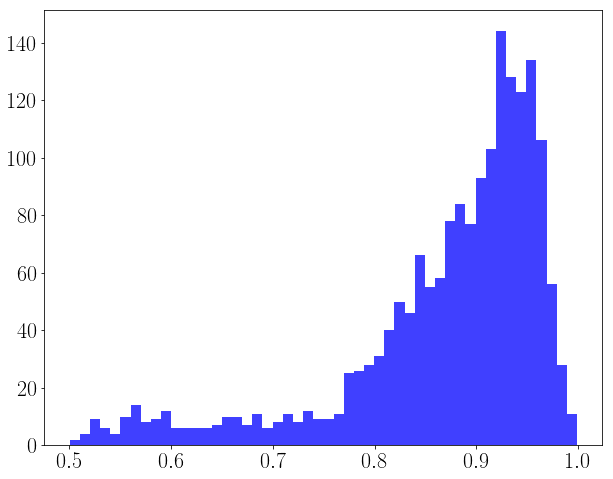

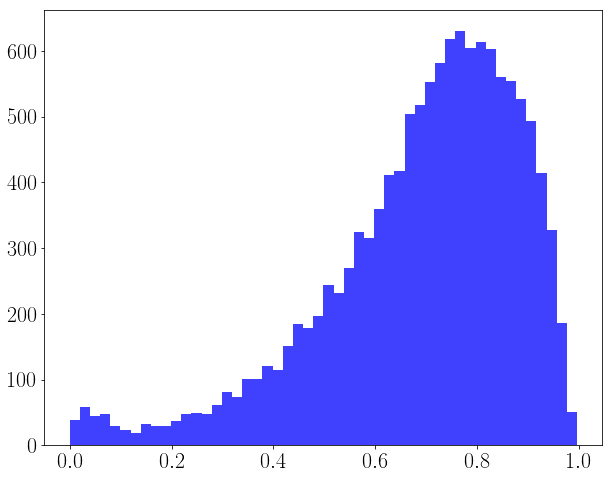

[[ 0.14830095  0.85169905]
 [ 0.09826027  0.90173973]
 [ 0.20643581  0.79356419]
 [ 0.25574459  0.74425541]
 [ 0.19702974  0.80297026]
 [ 0.13921727  0.86078273]
 [ 0.18507067  0.81492933]
 [ 0.08176065  0.91823935]
 [ 0.17218657  0.82781343]
 [ 0.18369475  0.81630525]
 [ 0.22080967  0.77919033]
 [ 0.38383834  0.61616166]
 [ 0.81692522  0.18307478]
 [ 0.30160929  0.69839071]
 [ 0.09550084  0.90449916]
 [ 0.21266363  0.78733637]
 [ 0.34415772  0.65584228]
 [ 0.20250477  0.79749523]
 [ 0.27026721  0.72973279]
 [ 0.13342159  0.86657841]]


In [17]:
resultsTestProb = gridsearchcv.best_estimator_.predict_proba(xMatrixTestExtended)
resultsTest = gridsearchcv.best_estimator_.predict(xMatrixTestExtended)
resultsTrainProb = gridsearchcv.best_estimator_.predict_proba(xMatrixTrainExtended)


# print(resultsTestProb)
# print()
resultsUnknown = gridsearchcv.best_estimator_.predict_proba(xMatrixUnknownExtended)

# print(resultsUnknown)

x = np.abs(resultsTest - y_testExtended)
# print(np.where(x !=0))

aux2 = np.array(resultsTestProb)
aux3 = np.array(y_testExtended)

indexA = (aux3 == 0) & (x == 0)
indexB = (aux3 == 1) & (x == 0)
indexC = (aux3 == 2) & (x == 0)
indexH = (aux3 == 3) & (x == 0)

# print(indexA)


acertos_A = resultsTestProb[indexA,0]
acertos_B = resultsTestProb[indexB,1]

index = np.where(x == 0)


aux = aux2[np.where(x==0),aux3[np.where(x==0)]]
plt.figure()
plt.hist(acertos_A, bins=50, facecolor='blue', alpha=0.75)
plt.show()


plt.figure()
plt.hist(resultsUnknown[:,1], 50, facecolor='blue', alpha=0.75)
plt.show()

print(resultsUnknown[:20,:])

In [15]:
dictionary = {'acc': acc, 'f1': F1, 'prec': prec, 'mean_test_score': means, 'std_test_score': stds, 
              'confMatrix': confusionMatrix, 'bestParams': gridsearchcv.best_params_, 'testData': xMatrixTestExtended,
             'testLabels': y_testExtended}
sio.savemat('results_class2_line.mat', dictionary)

pickle.dump( gridsearchcv, open( "model_class2_line.p", "wb" ) )